In [60]:
print()

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import os
import util
import pickle
from obspy import UTCDateTime
import obspy
import matplotlib
from matplotlib.patches import Rectangle
import scipy
from spectrum import *
import matplotlib.transforms as mtransforms
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/'

eq_list = os.listdir(root)

cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5_catalog.xml')

In [3]:
eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files') and os.path.exists(root+eq_name+'/picks.pkl'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])

In [4]:
list_tpmax = []
list_mags = []
list_mag_types = []
list_eq = []
flinnengdahl_regions = []
eqs = {}
count = 0

In [5]:
window_length=4; start_window=0; filter_limits=[1,19]; filter_corners=3; blank_time = 0.5

In [6]:
def new_gen(eq):
    plt.close()
    data = eq.data
    picks = eq.data_stats['picks']
    sensor_types = eq.data_stats['sensor_types']
    tau_p_list = []
    tp_max = []
    data_use = []
    data_use_unfiltered = []
    starts = []
    ends = []
    #print(data)
    for i in range(0, len(data)):  # iterate through all traces
        if data[i].stats.channel[2] == 'Z':  # only use vertical components
            trace = data[i].copy()
            station = trace.stats.station
            # station = station.ljust(4)
            tr_name = trace.stats.network+'.'+trace.stats.station+'.'+trace.stats.location
            if tr_name in picks.keys():
                # load saved parameters
                sampling_rate = trace.stats.sampling_rate
                pick = UTCDateTime(picks[tr_name])
                pick_samples = int(round((UTCDateTime(pick) - trace.stats.starttime)*trace.stats.sampling_rate, 0))
                snr = max(abs(trace.data[pick_samples:500+pick_samples]))/max(abs(trace.data[pick_samples-700:pick_samples-200]))
                if snr > 20:
                    # preprocess data
                    trace.detrend()
                    if sensor_types[i][0] == 'a':
                        trace.filter('highpass', freq=filter_limits[0], corners=filter_corners)  # 0.078)#i_freq)
                        trace = trace.integrate()
                    trace.filter('highpass', freq=filter_limits[0])
                    trace.filter('lowpass', freq=filter_limits[1])
                    data_use.append(trace.data)
                    data_use_unfiltered.append(data[i].data)
                    # tr.data[0:int((picks[i] - tr.stats.starttime)*sampling_rate)] = 0
                    alpha = 1-(1/sampling_rate)
                    x = trace.data
                    diff = (trace.differentiate()).data
                    X = np.zeros(len(x))
                    D = np.zeros(len(x))
                    start = int((pick - trace.stats.starttime)*sampling_rate)
                    end = int(start + window_length * sampling_rate)
                    starts.append(start); ends.append(end)
                    for t in range(0, len(trace.data)):
                        X[t] = alpha*X[t-1]+x[t]**2
                        D[t] = alpha*D[t-1]+diff[t]**2
                    tau_p = 2 * np.pi * np.sqrt(X/D)
                    tau_p_list.append(tau_p)
                    # print(max(tau_p[int(start+0.5*sampling_rate):int(end)]))
                    tp_max.append(max(tau_p[int(start+int(blank_time*sampling_rate)):int(end)]))
                    #plt.plot(tau_p[pick_samples:int(pick_samples+4*sample_rate)])
                    #plt_tp_all = eq.calculated_params['tau_p'][station]
                    plt_tp = ((tau_p[int(start):int(end)]))
                    #print(tp_max[-1])
                    #print(plt_tp)
                    plt.plot(plt_tp, color='black')
                    #print(eq.calculated_params['tau_p_max'][station])
                    #plt.axhline(tp_max[-1], 0, 4*sample_rate)
                    #plt.axvspan(0, blank_time*sampling_rate, 0, 1, color='grey',alpha=0.5)
                    #print(tp_max[-1])
                    #print(tau_p)
                    #plt.show()
    return tau_p_list, tp_max, data_use, starts, ends, data_use_unfiltered

In [7]:
def spectrum(tr, start, end):
    #print(type(tr))
    d = obspy.core.trace.Trace()
    d.data = np.array(tr)
    #plt.close()
    #plt.plot(d)
    #plt.show()
    #d = tr.copy()#.filter('lowpass', freq=10)
    #print(type(d))
    d.interpolate(100, 'lanczos', a = 20)
    d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
    d.filter('lowpass', freq = 19)
    d.detrend()
    d.integrate()
    d.detrend()
    #print(len(d))
    #print(start,end)
    coda = obspy.core.trace.Trace()
    coda.data = d.data[start:end]
    #print(len(coda))
    coda.detrend()
    #plt.plot(coda)
    #plt.show()

    dt = d.stats.delta
    #print(dt, len(coda))

    #creating the frequencies to plot on x axis 
    Pfreq  = scipy.fft.rfftfreq(len(coda),dt)

    #doing the multitaper to get the spectra 
    N = len(coda)
    NW=0.01*N
    k=25
    [tapers, eigen] = dpss(N, NW, k)
    for eigen_no in range(0, len(eigen)):
        if eigen[eigen_no] <= 0.5:
            k = eigen_no
            break
    [tapers, eigen] = dpss(N, NW, k)

    #print(eigen)
    freq_complex, weights, eigenvalues=pmtm(coda, e=eigen, v=tapers, show=False)
    freq = abs(freq_complex)
    freq = np.mean(freq,axis =0)
    freq_sdv = np.std(freq,axis =0)

    #plotting the spectra in loglog
    #print('plot')

    #axs.plot(Pfreq[:-1],freq[0:N//2]-min(freq[0:N//2]), alpha = 0.5, label=str(cat_with_data[eq_no].magnitudes[0].mag), color = cmap[eq_no])#tr_name + data[tr_no].stats.channel)
#plt.fill_between(Pfreq[:-1],(Sk+Sk_sdv)[0:N//2],(Sk-Sk_sdv)[0:N//2],alpha=0.2)
    #axs.set_xlabel('Frequency (Hz)');
    #axs.set_ylabel('A^2');
#plt.title(tr_name + data[tr_no].stats.channel+' coda wave Power spectra');
#else:
    #axs.plot(Pfreq[:-1],freq[0:N//2]-min(freq[0:N//2]), color = cmap[eq_no], alpha = 0.5)#tr_name + data[tr_no].stats.channel)

    return Pfreq, freq, N


3
3_0


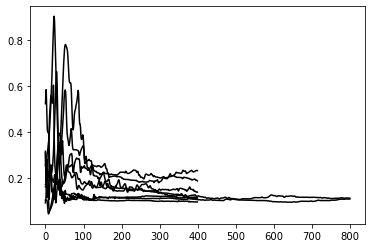

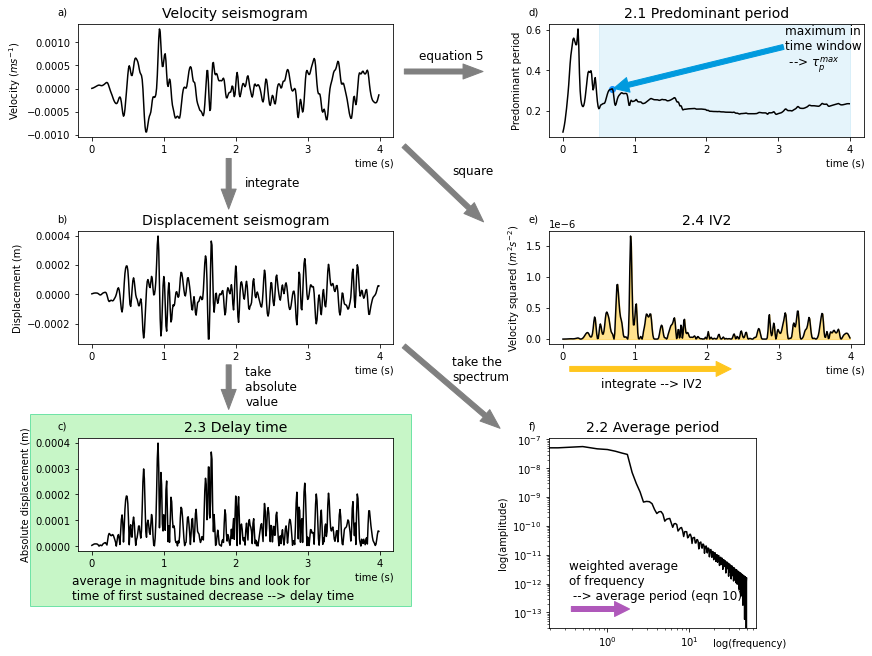

In [59]:
WINDOW_LENGTH = 1
%matplotlib inline
mosaic = """
aaa.ccc
aaa.ccc
.......
bbb.ddd
bbb.ddd
.......
eee.ff.
eee.ff.
....ff."""

for eq_no in [3]:#range(7, len(eq_with_data)):
    blank_samples = 50
    print(eq_no)
    #try:
    #print('loading')
    try:
        with open('/home/earthquakes1/homes/Rebecca/phd/data/2018_2021_global_m5/'+eq_with_data[eq_no]+'/eq_object_1s_bandpass_01_19_snr_20.pkl', 'rb') as picklefile:
            eq = pickle.load(picklefile)
    except:
        continue
    #for num_station in range(0, len(eq.calculated_params['tau_p_max'])):
        #distance = eq.calculated_params['iv2'][num_station][1]
        data = obspy.read(root+eq_with_data[eq_no]+'/data/*/*')
    #print('loaded')
    if eq.event_stats['eq_mag'] > 5 and eq.calculated_params['tau_p']!=[]:
        #print('big')
        tau_p_list, tp_max, data_use_z, starts, ends, data_use_unfiltered_z = new_gen(eq)
        #data_use = []
        #station = 0
        #data_station = 0
        for i in range(0, len(data_use_z)):
            #tr = data_use_z[i]
            #tr_name = tr.stats.network+'.'+tr.stats.station+'.'+tr.stats.location

            fig = plt.figure(constrained_layout=True,figsize=(12,9))
            ax = fig.add_subplot(111, frameon=False)
            plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

            ax.add_patch(Rectangle((0.0, 0.02), 0.46, 0.315,
            fc='lightgreen',
            color ='#00cd6c',
            linewidth = 1,
            alpha = 0.5))
                
            ax_dict = fig.subplot_mosaic(mosaic)
            

            
            #identify_axes(ax_dict)
            #x = np.arange(-100,4*sample_rate,1)
            ax_dict['a'].plot(data_use_z[i][starts[i]:ends[i]], color='k')
            
            to_diff = obspy.core.trace.Trace()
            to_diff.data = data_use_z[i]
            diffed = (to_diff.differentiate()).data
            ax_dict['b'].plot(diffed[starts[i]:ends[i]], color = 'k')
            
            ax_dict['c'].plot(tau_p_list[i][starts[i]:ends[i]], color='k')
            #print(np.argmax(tau_p_list[i][starts[i]+blank_samples:ends[i]])+blank_samples)
            #print(np.max(tau_p_list[i][starts[i]+50:ends[i]]))
            ax_dict['c'].scatter(np.argmax(tau_p_list[i][starts[i]+blank_samples:ends[i]])+blank_samples, np.max(tau_p_list[i][starts[i]+50:ends[i]]), color = 'dodgerblue')
            ax_dict['c'].axvspan(blank_samples,ends[i]-starts[i], color = '#009ade', alpha = 0.1)
            #axs[1].plot(x, eq.calculated_params['tau_p'][station][pick_samples-100:int(pick_samples+4*sample_rate)])
            
            squared = data_use_z[i][starts[i]:ends[i]]**2
            ax_dict['d'].plot(squared, color='k')
            ax_dict['d'].fill_between(np.arange(0,len(squared),1),squared, alpha = 0.5, color = '#ffc61e')
            
            ax_dict['e'].plot(abs(diffed[starts[i]:ends[i]]), color = 'k')
            #print(type(data_use_z))
            Pfreq, freq, N = spectrum(data_use_unfiltered_z[i],starts[i],ends[i])
            ax_dict['f'].plot(Pfreq[:-1],freq[0:N//2]-min(freq[0:N//2]), color='black')
            ax_dict['f'].set_xscale('log')
            ax_dict['f'].set_yscale('log')
            

            
            #JOINING ARROWS
            ax.annotate("",
            xy=(0.55, 0.9), xycoords='data',
            xytext=(0.45, 0.9), textcoords='data',
            arrowprops=dict(arrowstyle=("simple, head_width=1.5, head_length=2, tail_width = 0.5"),
                            connectionstyle="arc3",color='grey'),)
            ax.annotate("",
            xy=(0.55, 0.65), xycoords='data',
            xytext=(0.45, 0.78), textcoords='data',
            arrowprops=dict(arrowstyle=("simple, head_width=1.5, head_length=2, tail_width = 0.5"),
                            connectionstyle="arc3",color='grey'),)
            ax.annotate("",
            xy=(0.57, 0.31), xycoords='data',
            xytext=(0.45, 0.45), textcoords='data',
            arrowprops=dict(arrowstyle=("simple, head_width=1.5, head_length=2, tail_width = 0.5"),
                            connectionstyle="arc3",color='grey'),)
            ax.annotate("",
            xy=(0.24, 0.67), xycoords='data',
            xytext=(0.24, 0.76), textcoords='data',
            arrowprops=dict(arrowstyle=("simple, head_width=1.5, head_length=2, tail_width = 0.5"),
                            connectionstyle="arc3",color='grey'),)
            ax.annotate("",
            xy=(0.24, 0.34), xycoords='data',
            xytext=(0.24, 0.42), textcoords='data',
            arrowprops=dict(arrowstyle=("simple, head_width=1.5, head_length=2, tail_width = 0.5"),
                            connectionstyle="arc3",color='grey') )  

            ax2 = fig.add_subplot(111, frameon=False)
            plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
                
                
            #ANNOTATION ARROWS
            ax2.annotate("",
            xy=(0.85, 0.41), xycoords='data',
            xytext=(0.65, 0.41), textcoords='data',
            arrowprops=dict(arrowstyle=("simple, head_width=1.5, head_length=1.5, tail_width = 0.5"),
                           connectionstyle="arc3", color = '#ffc61e'),)

            
            x = (np.argmax(tau_p_list[i][starts[i]+blank_samples:ends[i]])+blank_samples)
            y = (np.max(tau_p_list[i][starts[i]+blank_samples:ends[i]]))
            ax_dict['c'].annotate("",
                        xy=(x, y), xycoords='data',
                        xytext=(0.75, 0.8), textcoords='axes fraction',color='blue',
                        arrowprops=dict(arrowstyle=("simple, head_width=1.5, head_length=1.5, tail_width = 0.5"),
                           connectionstyle="arc3", color = '#009ade'),)
            
            ax_dict['c'].annotate("maximum in \ntime window\n --> "+r"$\tau _p ^{max}$",
                        xy=(x, y), xycoords='data',
                        xytext=(0.75, 0.62), textcoords='axes fraction',fontsize=12)
            

            ax_dict['f'].annotate("",
                        xy=(0.4, 0.1), xycoords='axes fraction',
                        xytext=(0.1, 0.1), textcoords='axes fraction',color='yellow',
                        arrowprops=dict(arrowstyle=("simple, head_width=1.5, head_length=1.5, tail_width = 0.5"),
                           connectionstyle="arc3", color = '#af58ba'),)
            
            ax_dict['f'].annotate("weighted average \nof frequency \n --> average period (eqn 10)",
                        xy=(0.1, 0.15), xycoords='axes fraction',
                        xytext=(0.1, 0.15), textcoords='axes fraction',color='black',fontsize=12)
            
            #TEXT ANNOTATIONS
            
            ax.annotate("equation 5",
            xy=(0.5, 0.92), xycoords='data',
            xytext=(0.47, 0.92), textcoords='data',fontsize=12)            

            ax.annotate("integrate",
            xy=(0.26, 0.71), xycoords='data',
            xytext=(0.26, 0.71), textcoords='data',fontsize=12)   
            
            ax.annotate("take \nabsolute \nvalue",
            xy=(0.26, 0.36), xycoords='data',
            xytext=(0.26, 0.35), textcoords='data',fontsize=12)   
            
            ax.annotate("square",
            xy=(0.51, 0.73), xycoords='data',
            xytext=(0.51, 0.73), textcoords='data',fontsize=12)   
            
            ax.annotate("take the \nspectrum",
            xy=(0.51, 0.39), xycoords='data',
            xytext=(0.51, 0.39), textcoords='data',fontsize=12)   
            
            ax.annotate("average in magnitude bins and look for \ntime of first sustained decrease --> delay time",
            xy=(0.05, 0.05), xycoords='data',
            xytext=(0.05, 0.03), textcoords='data',fontsize=12) 
            
            ax2.annotate("integrate --> IV2",
            xy=(0.69, 0.38), xycoords='data',
            xytext=(0.69, 0.38), textcoords='data',fontsize=12) 
            
            ax3 = fig.add_subplot(111, frameon=False)
            plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
            
            #x = np.argmin(tau_p_list[i][starts[i]+blank_samples:ends[i]])+blank_samples
            #y = np.max(tau_p_list[i][starts[i]+blank_samples:ends[i]])
            #x, y = 0,0
            #ax3.annotate("text",
            #            xy=(x+0.57, y+0.77), xycoords='data',
            #            xytext=(1, 1), textcoords='data',color='blue',
            #arrowprops=dict(arrowstyle=("simple, head_width=1.5, head_length=2, tail_width = 0.5"),
            #               connectionstyle="arc3", color = 'orange'),zorder= 10000) # where is this arrow????????
            label_list = ['a)','d)','b)','e)','c)','f)']
            label_count = 0
            for label, ax in ax_dict.items():
                # label physical distance to the left and up:
                trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
                ax.text(0.0, 1.0, label_list[label_count], transform=ax.transAxes + trans,
                fontsize='medium', va='bottom')
                label_count += 1
            ax_dict['a'].set_xlabel('time (s)', horizontalalignment='right',x=1)
            ax_dict['b'].set_xlabel('time (s)', horizontalalignment='right',x=1)
            ax_dict['c'].set_xlabel('time (s)', horizontalalignment='right',x=1)
            ax_dict['d'].set_xlabel('time (s)', horizontalalignment='right',x=1)
            ax_dict['e'].set_xlabel('time (s)', horizontalalignment='right',x=1)
            ax2.set_xlabel('log(frequency)', x=0.87)
            
            ax_dict['a'].set_title('Velocity seismogram',fontsize=14)
            ax_dict['b'].set_title('Displacement seismogram',fontsize=14)
            ax_dict['c'].set_title('2.1 Predominant period',fontsize=14)
            ax_dict['d'].set_title('2.4 IV2',fontsize=14)
            ax_dict['e'].set_title('2.3 Delay time',fontsize=14)
            ax_dict['f'].set_title('2.2 Average period',fontsize=14)
            
            ax_dict['a'].set_ylabel('Velocity ($ms^{-1}$)')
            ax_dict['b'].set_ylabel('Displacement (m)')
            ax_dict['c'].set_ylabel('Predominant period')
            ax_dict['d'].set_ylabel('Velocity squared ($m^2s^{-2}$)')
            ax_dict['e'].set_ylabel('Absolute displacement (m)')
            ax_dict['f'].set_ylabel('log(amplitude)')
            
            ax_dict['a'].set_xticks(np.linspace(0, ends[i]-starts[i],5), [0,1,2,3,4])
            ax_dict['b'].set_xticks(np.linspace(0, ends[i]-starts[i],5), [0,1,2,3,4])
            ax_dict['c'].set_xticks(np.linspace(0, ends[i]-starts[i],5), [0,1,2,3,4])
            ax_dict['d'].set_xticks(np.linspace(0, ends[i]-starts[i],5), [0,1,2,3,4])
            ax_dict['e'].set_xticks(np.linspace(0, ends[i]-starts[i],5), [0,1,2,3,4])            

            
            #ax2.annotate("Frequency (Hz)",
            #xy=(0.05, 0.), xycoords='data',
            #xytext=(0.85, 0.), textcoords='axes fraction') 
            
            #ax_dict['f'].set_xlabel('frequency (Hz)', horizontalalignment='right',x=1)
            print(str(eq_no)+'_'+str(i))
            #plt.savefig('/home/earthquakes1/homes/Rebecca/phd/figures/method_summary_figs/'+eq_with_data[eq_no]+'_'+tr_name)
            #plt.savefig('/home/earthquakes1/homes/Rebecca/phd/figures/method_summary_figs/'+eq_with_data[eq_no]+'_'+str(i),format = 'pdf')
            plt.show()
            break
            
    else:
        print('small')


In [44]:
np.linspace(0, ends[i]-starts[i],5)

array([  0., 100., 200., 300., 400.])